In [1102]:
import sdeint
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import itertools
import time
import KM_EWS_methods
import importlib
importlib.reload(KM_EWS_methods)

<module 'KM_EWS_methods' from '/Users/andreasmorr/Library/Mobile Documents/com~apple~CloudDocs/PhD Studium/Eigene Papers/KramersMoyalEWS/KramersMoyalEWS/KM_EWS_methods.py'>

Plot specifications

In [1103]:
plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams.update({'font.family': 'serif',
                     'text.usetex': True,
                     'font.serif': ['Helvetica'],
                     'font.size': 2*8,
                     'axes.labelsize': 2*8,
                     'axes.titlesize': 2*12,
                     'figure.titlesize': 2*14})
samplecolor = "black"
errorcolor = "grey"
theocolor = "red"
eigval1meancolor = "#ba4502"
eigval1errorcolor = "#b5693e"
eigval2meancolor = "#02b570"
eigval2errorcolor = "#74b39a"
kmcolorrange = matplotlib.colormaps["cool"]
samplelinewidth = 1*2
errorlinewidth = 0.7*2
theolinewidth = 1*2

Define the parameters and functions of the fold bifurcation

In [1104]:
T = 1000 # length of the time series in units of time
OneOverDelta_t = 10 # Delta_t is the sampling time step of the time series
Delta_t = 1/OneOverDelta_t
oversampling = 10 # the SDE integration is done at a time step which is oversampling* finer than the sampling time step.
int_tspan = np.linspace(0, T, T * OneOverDelta_t * oversampling,endpoint=False)
plt_tspan = np.linspace(0, T, T * OneOverDelta_t,endpoint=False)
alpha_0 = 1 # start of bifurcation parameter evolution
alpha_T = -0.1 # end of bifurcation parameter evolution
sigma_0 = 0.2 # start of noise strength parameter evolution
sigma_T = 0.06 # end of noise strength parameter evolution
T_measure = round((alpha_0 - 0.1) / (alpha_0 - alpha_T) * T) # time span for estimations to exclude noise tipping
T_posalpha = round(alpha_0 / (alpha_0 - alpha_T) * T) # time span for theoretical estimator values (for linear \alpha evolution)
x_0 = np.array([alpha_0**(0.5)]) # initial value of the SDE integration
x_off = -2 # x state after bifurcation


# bifurcation parameter evolution
def alpha(t):
    return alpha_0 * (1 - t/T) + alpha_T * t/T

# noise strength parameter evolution
def sigma(t):
    return sigma_0*(1-t/T)+sigma_T*t/T

# fold bifurcation normal form
def f(x,t):
    if x[0]>x_off / 2:
        return np.array([-(x[0])**2 + alpha(t)])
    else:
        return -(x[0] - x_off)

# noise strength matrix
def G(x,t):
    return np.array([[sigma(t)]])

# linearised restoring force in x dimension, specifically for fold bifurcation
def lambda_x(alpha):
    return 2 * np.sqrt(alpha)

Integrate a collection of sample paths

In [1105]:
samplesize = 10 # number of sample paths to perform estimations on
samplepaths = []
for i in range(samplesize):
    integration = sdeint.itoint(f,G,x_0,int_tspan)
    samplepaths.append(np.transpose(integration[::oversampling]))

Define the theoretical functions for the variance and lag-1 autocorrelation of the observable as functions of the linear restoring rate $\lambda_x$. Also define the theoretical fixed points as a function of the parameter $\alpha$.

In [1106]:
def theovar(t):
    return G([theoxfix(alpha(t))],t)[0,0]**2/(2*lambda_x(alpha(t)))

def theoac1(t):
    return np.exp(-lambda_x(alpha(t))*Delta_t)

def theoxfix(alpha):
    if alpha >= 0:
        return np.sqrt(alpha)
    else:
        return x_off


Define estimation constraints

In [1107]:
windowsize = 100 * OneOverDelta_t # estimation windowsize in units of individual data points sampled at time step Delta_t
leap = 10 * OneOverDelta_t # leap between sucessive estimations in units of individual data points sampled at time step Delta_t
kmleapfactor = 10 # skip this many KM visualisations in the color plots
number_of_windows = (T_measure * OneOverDelta_t - windowsize)// leap # number of estimation windows resulting
colorsteps = round(number_of_windows/kmleapfactor)+1 # number of disjoint colored estiamtion windows resulting

Calculate conventional EWS

In [1108]:
samplevars = []
sampleac1s = []
for i in range(samplesize):
    samplevars.append([])
    sampleac1s.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        samplevars[i].append(KM_EWS_methods.variance_estimator(samplepaths[i][0][j: j + windowsize]))
        sampleac1s[i].append(KM_EWS_methods.ac1_estimator(samplepaths[i][0][j: j + windowsize]))
samplevars = np.array(samplevars)
sampleac1s = np.array(sampleac1s)

meansamplevar = np.mean(samplevars, axis = 0)
meansampleac1 = np.mean(sampleac1s, axis = 0)

Calculate KM coefficients

In [1109]:
sampleedges = []
samplekm1 = []
samplekm2 = []
samplelambdas = []
for i in range(samplesize):
    sampleedges.append([])
    samplekm1.append([])
    samplekm2.append([])
    samplelambdas.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        km_analysis_results = KM_EWS_methods.full_km_analysis(samplepaths[i][0][j: j + windowsize], Delta_t) # See more specifics in the file KM_EWS_methods.py
        sampleedges[i].append(km_analysis_results[0])
        samplekm1[i].append(km_analysis_results[1])
        samplekm2[i].append(km_analysis_results[2])
        samplelambdas[i].append(km_analysis_results[3])


sampleedges = np.array(sampleedges)
samplekm1 = np.array(samplekm1)
samplekm2 = np.array(samplekm2)
samplelambdas = np.array(samplelambdas)

meansamplelambda = np.mean(samplelambdas, axis = 0)

Plot KM coefficients

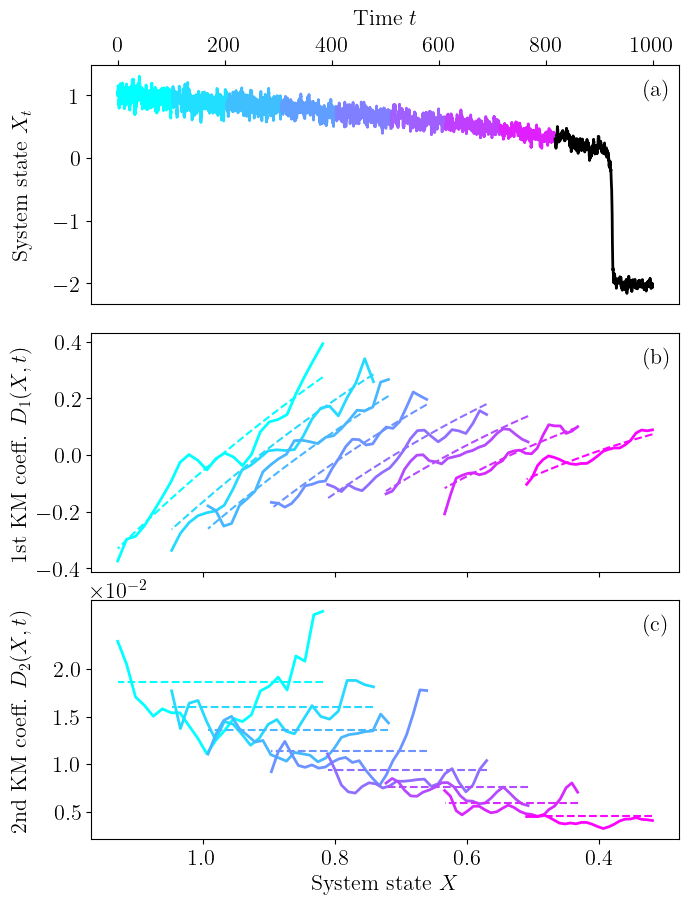

In [1110]:
fig, [xplt, km1plt, km2plt] = plt.subplots(nrows=3, ncols=1,figsize=(2*3.42, 2*4.5), gridspec_kw={'height_ratios': [1, 1, 1]})

props = dict(edgecolor="none", facecolor='white', alpha=0)
for k in range(colorsteps):
    xplt.plot(plt_tspan[k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)],samplepaths[0][0][k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)], color = kmcolorrange(k/colorsteps), linewidth = samplelinewidth)
xplt.plot(plt_tspan[T_measure*OneOverDelta_t:],samplepaths[0][0][T_measure*OneOverDelta_t:], color = samplecolor, linewidth = samplelinewidth)
xplt.xaxis.tick_top()
xplt.xaxis.set_label_position("top")
xplt.set_ylabel("System state $X_t$")
xplt.set_xlabel("Time $t$", labelpad=8)
xplt.text(0.94, 0.94, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
for j in range(0,number_of_windows,kmleapfactor):
    km1plt.plot(sampleedges[0][j], samplekm1[0][j], color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)
    km1plt.plot(sampleedges[0][j], [f([x],plt_tspan[j*leap+windowsize//2])[0] for x in sampleedges[0][j]],linestyle = "dashed", color = kmcolorrange(j/number_of_windows))
km1plt.set_ylabel("1st KM coeff. $D_1(X,t)$")
km1plt.text(0.94, 0.94, "(b)", transform=km1plt.transAxes, verticalalignment='top', bbox=props)
km1plt.set_xticklabels([])
km1plt.set_xlim(km1plt.get_xlim()[1],km1plt.get_xlim()[0])
for j in range(0,number_of_windows,kmleapfactor):
    km2plt.plot(sampleedges[0][j], samplekm2[0][j] * 100, color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)  
    km2plt.plot(sampleedges[0][j], [G([x],plt_tspan[j*leap+windowsize//2])[0,0]**2/2 * 100 for x in sampleedges[0][j]], linestyle = "dashed", color = kmcolorrange(j/number_of_windows))
km2plt.set_ylabel("2nd KM coeff. $D_2(X,t)$")
km2plt.text(0.94, 0.94, "(c)", transform=km2plt.transAxes, verticalalignment='top', bbox=props)
km2plt.set_xlim(km2plt.get_xlim()[1],km2plt.get_xlim()[0])
km2plt.set_yticks([.5,1.0,1.5,2.0])
#km2plt.set_xticks(km2plt.get_xticks(),np.round(-km2plt.get_xticks(),2))
km2plt.set_xlabel("System state $X$")
km2plt.text(0.0,1.02, r'$\times 10^{-2}$', transform=km2plt.transAxes)

[plots.yaxis.set_label_coords(-0.1,.5) for plots in [xplt, km1plt, km2plt]]

fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.93, hspace=.12, wspace=.2)
#fig.savefig("Plots/FoldObservableKM" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True)

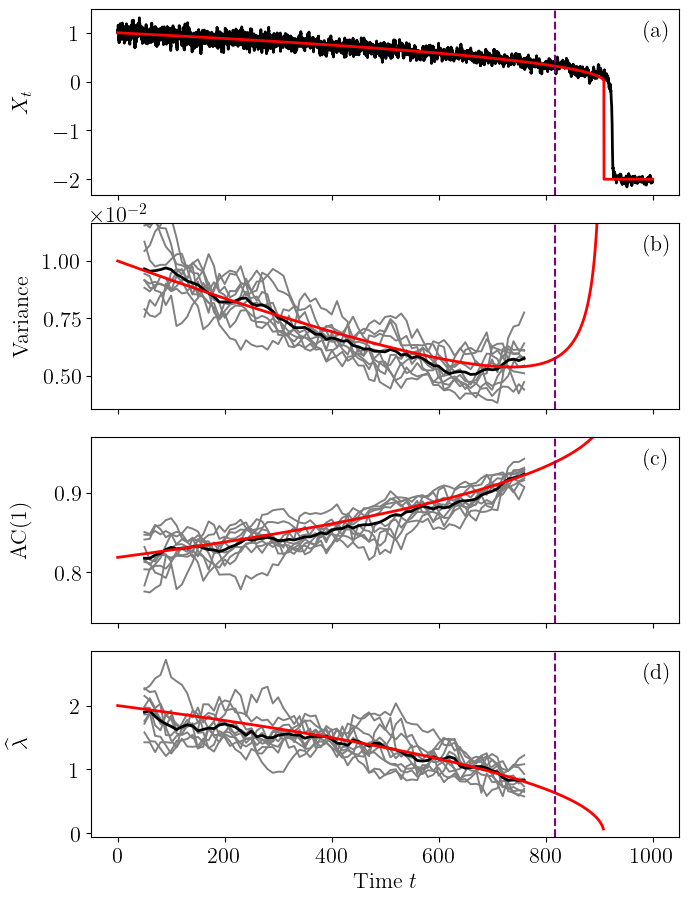

In [1111]:
fig, [xplt, varplt, ac1plt, linkm1plt] = plt.subplots(nrows=4, ncols=1,figsize=(3.42*2, 4.5*2),gridspec_kw={'height_ratios': [1, 1, 1, 1]}, sharex=True)
props = dict(edgecolor="none", facecolor='white', alpha=0)
xplt.plot(plt_tspan, samplepaths[0][0], color = samplecolor, linewidth = samplelinewidth)
xplt.plot(plt_tspan,[theoxfix(alpha(t)) for t in plt_tspan], color = theocolor, linewidth = theolinewidth)
xplt.axvline(T_measure, linestyle = "dashed", color = "purple")
xplt.set_ylabel("$X_t$")
xplt.text(0.94, 0.94, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
for i in range(samplesize):
    varplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), samplevars[i], color = errorcolor, linewidth = errorlinewidth)
varplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplevar, color = samplecolor, linewidth = theolinewidth)
varplt.plot([theovar(t) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
varplt.axvline(T_measure, linestyle = "dashed", color = "purple")
varplt.set_ylabel("Variance")
varplt.ticklabel_format(axis="y",style="sci",scilimits=(-1,1))
varplt.set_ylim([0.7 * min(meansamplevar), 1.2 * max(meansamplevar)])
varplt.text(0.94, 0.94, "(b)", transform=varplt.transAxes, verticalalignment='top', bbox=props)
for i in range(samplesize):
    ac1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), sampleac1s[i], color = errorcolor, linewidth = errorlinewidth)
ac1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansampleac1, color = samplecolor, linewidth = theolinewidth)
ac1plt.plot([theoac1(t) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
ac1plt.axvline(T_measure, linestyle = "dashed", color = "purple")
ac1plt.set_ylabel("AC(1)")
ac1plt.set_ylim([0.9 * min(meansampleac1), 1.05 * max(meansampleac1)])
ac1plt.text(0.94, 0.94, "(c)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
for i in range(samplesize):
    linkm1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), samplelambdas[i], color = errorcolor, linewidth = errorlinewidth)
linkm1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplelambda, color = samplecolor, linewidth = theolinewidth)
linkm1plt.plot([lambda_x(alpha(t)) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
linkm1plt.axvline(T_measure, linestyle = "dashed", color = "purple")
linkm1plt.set_ylabel("$\widehat{\lambda}$")
linkm1plt.text(0.94, 0.94, "(d)", transform=linkm1plt.transAxes, verticalalignment='top', bbox=props)
linkm1plt.set_xlabel("Time $t$")

[plots.yaxis.set_label_coords(-0.1,.5) for plots in [xplt, varplt, ac1plt, linkm1plt]]

fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.99, hspace=.15, wspace=.2)
#fig.savefig("Plots/FoldVarAC1Lam" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True)

Define the Predator Prey Model

In [1145]:
T = 500 # length of the time series in units of time
prerun = 1 # time to allow for equilibration of the system
OneOverDelta_t = 100 # Delta_t is the sampling time step of the time series
Delta_t = 1/OneOverDelta_t
oversampling = 10 # the SDE integration is done at a time step which is oversampling* finer than the sampling time step.
int_tspan = np.linspace(-prerun, T, (T+prerun) * OneOverDelta_t*oversampling,endpoint=False)
plt_tspan = np.linspace(0, T, T * OneOverDelta_t,endpoint=False)
turb_0 = 2.2/2.2 # start of bifurcation parameter evolution
turb_T = 0.71/2.2 # end of bifurcation parameter evolution
T_measure = round(0.8*T)#round((turb_0 - 0.75) / (turb_0 - turb_T) * T) # time span for estimations (for linear \turb evolution)
T_posturb = round(turb_0 / (turb_0 - turb_T) * T) # time span for theoretical estimator values (for linear \turb evolution)
pz_0 = np.array([0.62,2.1]) # initial value of the SDE integration
epsilon = 0.05
speeding = 1
sqrtspeeding = speeding**0.5

r = 1
a = 1/9
m_z = 0.0525
xi = 0.1
h_0 = 1/16
c_h = 0.4*2.2
K_0 = 0.7
c_K = 0.3*2.2

p_scaling = 1

# bifurcation parameter evolution
def turb(t):
    return turb_0 * (1 - t/T) + turb_T * t/T


def h(turb):
    return h_0/(1+turb*c_h)


def g(p,turb):
    return a*p**2/(h(turb)**2+p**2)


def K(turb):
    return K_0+turb*c_K


# deterministic evolution, fold bifurcation normal form
def f(pz,t):
    return speeding*np.array([xi**-1*(r*(pz[0]/p_scaling)*(1-(pz[0]/p_scaling)/K(turb(t)))-g((pz[0]/p_scaling),turb(t))*pz[1]),g((pz[0]/p_scaling),turb(t))*pz[1]-m_z*pz[1]**2])


# noise strength matrix
def G(pz,t):
    return sqrtspeeding*epsilon*np.array([[xi**-0.5 * pz[0],0],[0,0.1*pz[1]]])

Integrate a collection of sample paths

In [1146]:
samplesize = 10 # number of sample paths to perform estimations on
samplepaths = []
for i in range(samplesize):
    integration = sdeint.itoint(f,G,pz_0,int_tspan)
    samplepaths.append(np.transpose(integration[prerun*OneOverDelta_t*oversampling::oversampling]))


Plot the bifurcation diagram of the system

/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_6942/2006657708.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  tplt.set_xticklabels([round(turb(t),2) for t in pplt.get_xticks()])


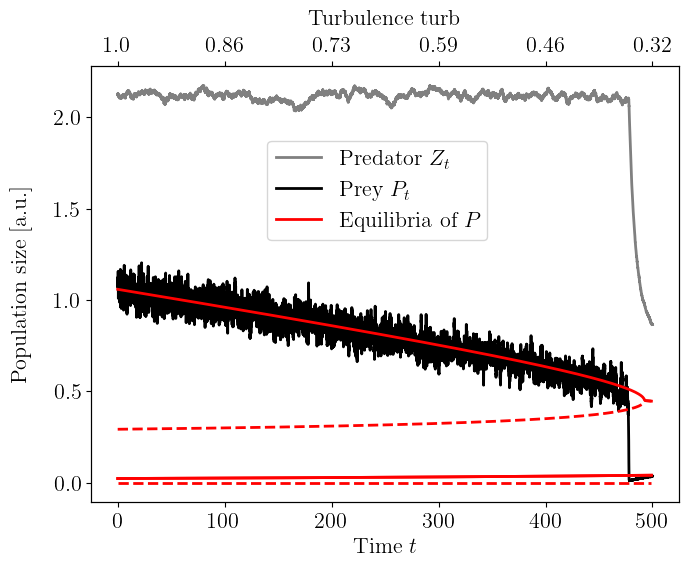

In [1147]:
#upperunst = [optimize.root(f,x0=[2,2],args=(k)).x[0] for k in range(T)]
#print(upperunst)
lowerst = [optimize.root(f,x0=[0.05,1],args=(k)).x[0] for k in range(T)]
midunst = [optimize.root(f,x0=[0.4,2],args=(k)).x[0] for k in range(T)]
midst = [optimize.root(f,x0=[1,2],args=(k)).x[0] for k in range(T)]
fig, pplt = plt.subplots(nrows=1, ncols=1,figsize=(3.42*2, 2.8*2))
tplt = pplt.twiny()
pplt.plot(plt_tspan,samplepaths[0][1], color = "grey", linewidth = samplelinewidth)
pplt.plot(plt_tspan,samplepaths[0][0], color = "black", linewidth = samplelinewidth)
pplt.plot(lowerst, color = "red", linewidth = theolinewidth)
pplt.plot(np.zeros(T), color = "red", linewidth = theolinewidth, linestyle = "dashed")
#pplt.plot(upperunst, color = "red", linewidth = 1, linestyle = "dashed")
pplt.plot(lowerst, color = "red", linewidth = theolinewidth)
pplt.plot(midunst, color = "red", linewidth = theolinewidth, linestyle = "dashed")
pplt.plot(midst, color = "red", linewidth = theolinewidth)
pplt.set_ylabel("Population size [a.u.]")
pplt.set_xlabel("Time $t$")
pplt.legend(["Predator $Z_t$", "Prey $P_t$", "Equilibria of $P$"], loc=(0.3,0.6))
tplt.set_xlim(pplt.get_xlim())
#tplt.set_xticks(pplt.get_xticks())
tplt.set_xticklabels([round(turb(t),2) for t in pplt.get_xticks()])
tplt.set_xlabel(r"Turbulence turb", labelpad=8)
pplt.yaxis.set_label_coords(-0.1,.5)
fig.subplots_adjust(left=.13, bottom=.11, right=.99, top=.89)
#fig.savefig("Plots/PPBifDiag" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True)

Define estimation constraints

In [1148]:
windowsize = 50 * OneOverDelta_t # estimation windowsize in units of individual data points sampled at time step Delta_t
leap = 5 * OneOverDelta_t # leap between sucessive estimations in units of individual data points sampled at time step Delta_t
kmleapfactor = 10 # skip this many KM visualisations in the color plots
number_of_windows = (T_measure * OneOverDelta_t - windowsize)// leap # number of estimation windows resulting
colorsteps = round(number_of_windows/kmleapfactor)+1 # number of disjoint colored estiamtion windows resulting

Calculate conventional EWS

In [1149]:
samplevars = []
sampleac1s = []
for i in range(samplesize):
    samplevars.append([])
    sampleac1s.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        samplevars[i].append(KM_EWS_methods.variance_estimator(samplepaths[i][0][j: j + windowsize]))
        sampleac1s[i].append(KM_EWS_methods.ac1_estimator(samplepaths[i][0][j: j + windowsize]))
samplevars = np.array(samplevars)
sampleac1s = np.array(sampleac1s)

meansamplevar = np.mean(samplevars, axis = 0)
meansampleac1 = np.mean(sampleac1s, axis = 0)

Calculate KM coefficients

In [1150]:
sampleedges = []
samplekm1 = []
samplekm2 = []
samplelambdas = []
for i in range(samplesize):
    sampleedges.append([])
    samplekm1.append([])
    samplekm2.append([])
    samplelambdas.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        km_analysis_results = KM_EWS_methods.full_km_analysis(samplepaths[i][0][j: j + windowsize], Delta_t) # See more specifics in the file KM_EWS_methods.py
        sampleedges[i].append(km_analysis_results[0])
        samplekm1[i].append(km_analysis_results[1])
        samplekm2[i].append(km_analysis_results[2])
        samplelambdas[i].append(km_analysis_results[3])


sampleedges = np.array(sampleedges)
samplekm1 = np.array(samplekm1)
samplekm2 = np.array(samplekm2)
samplelambdas = np.array(samplelambdas)

meansamplelambda = np.mean(samplelambdas, axis = 0)

Plot KM coefficients

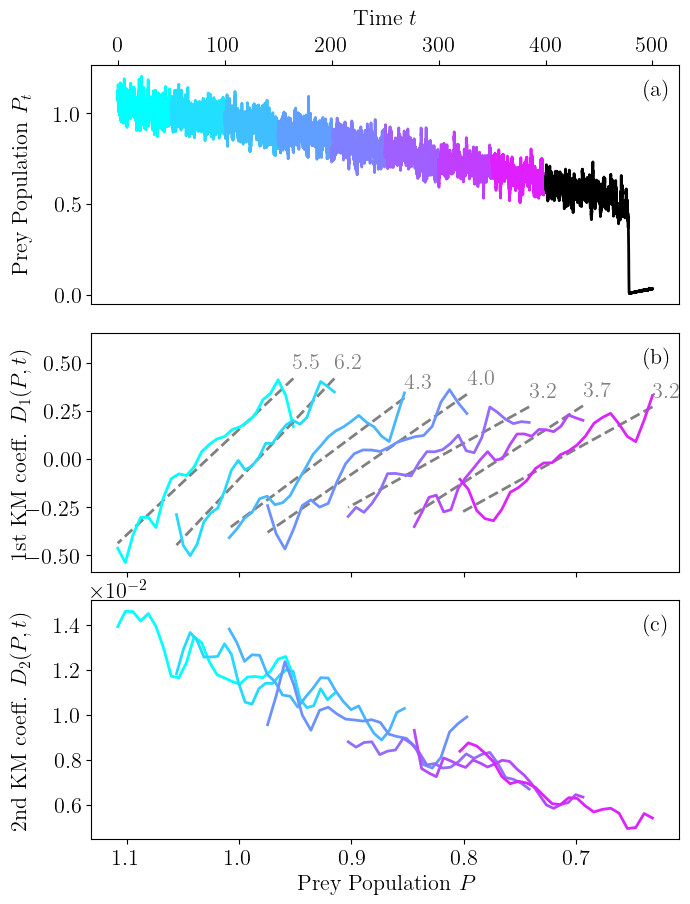

In [1151]:
fig, [xplt, km1plt, km2plt] = plt.subplots(nrows=3, ncols=1,figsize=(3.42*2, 4.5*2), gridspec_kw={'height_ratios': [1, 1, 1]})

props = dict(edgecolor="none", facecolor='white', alpha=0)
for k in range(colorsteps):
    xplt.plot(plt_tspan[k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)],samplepaths[0][0][k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)], color = kmcolorrange(k/colorsteps), linewidth = samplelinewidth)
xplt.plot(plt_tspan[T_measure*OneOverDelta_t:],samplepaths[0][0][T_measure*OneOverDelta_t:], color = samplecolor, linewidth = samplelinewidth)
xplt.xaxis.tick_top()
xplt.xaxis.set_label_position("top")
xplt.set_xlabel("Time $t$", labelpad=8)
xplt.set_ylabel("Prey Population $P_t$")
xplt.text(0.94, 0.94, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
for j in range(0,number_of_windows,kmleapfactor):
    m_fit, b_fit = np.polyfit(sampleedges[0][j], samplekm1[0][j], 1)
    km1plt.plot(sampleedges[0][j], m_fit*sampleedges[0][j]+b_fit, color = errorcolor, linewidth = theolinewidth, linestyle = "dashed")
    km1plt.text(sampleedges[0][j][0], m_fit*sampleedges[0][j][0]+b_fit+0.05, str(round(samplelambdas[0][j],1)),color=errorcolor)
    #km1plt.scatter([sampleedges[0][j][len(sampleedges[0][j])//2]],[m_fit*sampleedges[0][j][len(sampleedges[0][j])//2]+b_fit],color="red")
    km1plt.plot(sampleedges[0][j], samplekm1[0][j], color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)
km1plt.set_ylabel("1st KM coeff. $D_1(P,t)$")
km1plt.text(0.94, 0.94, "(b)", transform=km1plt.transAxes, verticalalignment='top', bbox=props)
km1plt.set_xticklabels([])
km1plt.set_xlim(km1plt.get_xlim()[1],km1plt.get_xlim()[0])
km1plt.set_ylim(km1plt.get_ylim()[0],km1plt.get_xlim()[1]+0.05)
for j in range(0,number_of_windows,kmleapfactor):
    km2plt.plot(sampleedges[0][j], samplekm2[0][j] * 100, color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)  
km2plt.set_ylabel("2nd KM coeff. $D_2(P,t)$")
km2plt.text(0.94, 0.94, "(c)", transform=km2plt.transAxes, verticalalignment='top', bbox=props)
km2plt.set_xlim(km2plt.get_xlim()[1],km2plt.get_xlim()[0])
#km2plt.set_xticks(km2plt.get_xticks(),np.round(-km2plt.get_xticks(),2))
km2plt.set_xlabel("Prey Population $P$")

km2plt.set_yticks([.6,.8,1.0,1.2,1.4])
#km2plt.set_xticks(km2plt.get_xticks(),np.round(-km2plt.get_xticks(),2))
km2plt.text(0.0,1.02, r'$\times 10^{-2}$', transform=km2plt.transAxes)

[plots.yaxis.set_label_coords(-0.1,.5) for plots in [xplt, km1plt, km2plt]]

fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.93, hspace=.12, wspace=.2)
#fig.savefig("Plots/PPKM" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True)

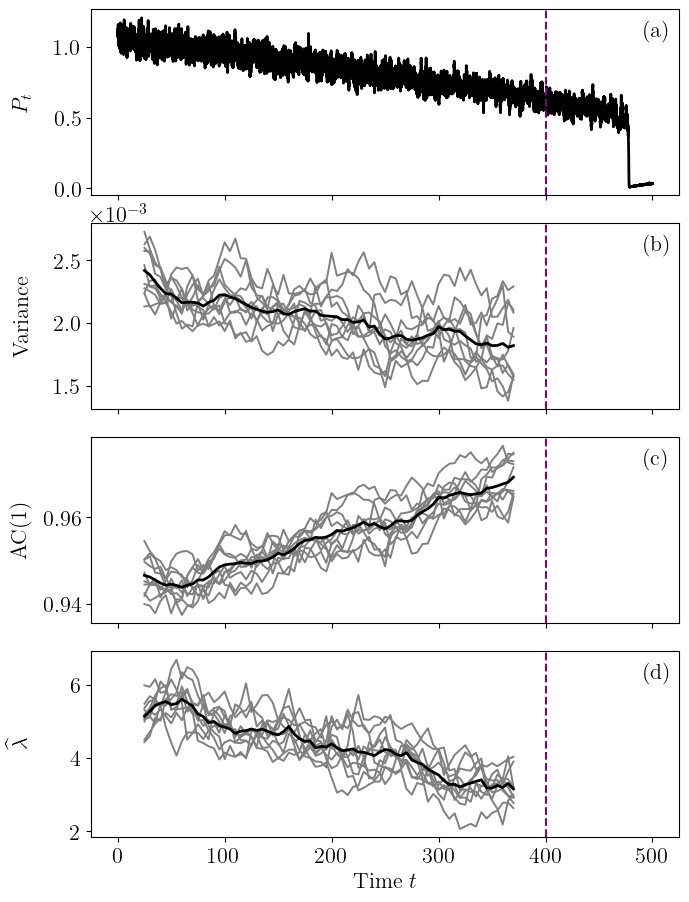

In [1152]:
fig, [xplt, varplt, ac1plt, linkm1plt] = plt.subplots(nrows=4, ncols=1,figsize=(3.42*2, 4.5*2),gridspec_kw={'height_ratios': [1, 1, 1, 1]}, sharex=True)
props = dict(edgecolor="none", facecolor='white', alpha=0)
xplt.plot(plt_tspan, samplepaths[0][0], color = samplecolor, linewidth = samplelinewidth)
xplt.axvline(T_measure, linestyle = "dashed", color = "purple")
xplt.set_ylabel("$P_t$")
xplt.text(0.94, 0.94, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
for i in range(samplesize):
    varplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), samplevars[i], color = errorcolor, linewidth = errorlinewidth)
varplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplevar, color = samplecolor, linewidth = theolinewidth)
varplt.axvline(T_measure, linestyle = "dashed", color = "purple")
varplt.set_ylabel("Variance")
varplt.ticklabel_format(axis="y",style="sci",scilimits=(-1,1))
#varplt.set_ylim([0.7 * min(meansamplevar), 1.2 * max(meansamplevar)])
varplt.text(0.94, 0.94, "(b)", transform=varplt.transAxes, verticalalignment='top', bbox=props)
for i in range(samplesize):
    ac1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), sampleac1s[i], color = errorcolor, linewidth = errorlinewidth)
ac1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansampleac1, color = samplecolor, linewidth = theolinewidth)
ac1plt.axvline(T_measure, linestyle = "dashed", color = "purple")
ac1plt.set_ylabel("AC(1)")
#ac1plt.set_ylim([0.99 * min(meansampleac1), 1.01 * max(meansampleac1)])
ac1plt.text(0.94, 0.94, "(c)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
for i in range(samplesize):
    linkm1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), samplelambdas[i], color = errorcolor, linewidth = errorlinewidth)
linkm1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplelambda, color = samplecolor, linewidth = theolinewidth)
linkm1plt.axvline(T_measure, linestyle = "dashed", color = "purple")
linkm1plt.set_ylabel("$\widehat{\lambda}$")
linkm1plt.text(0.94, 0.94, "(d)", transform=linkm1plt.transAxes, verticalalignment='top', bbox=props)
linkm1plt.set_xlabel("Time $t$")

[plots.yaxis.set_label_coords(-0.1,.5) for plots in [xplt, varplt, ac1plt, linkm1plt]]

fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.99, hspace=.15, wspace=.2)

#fig.savefig("Plots/PPVarAC1linLam" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True) 


Perform KM analysis on the 2D data

In [1153]:
importlib.reload(KM_EWS_methods)
samplemeshs = []
samplekmcs = []
samplelambdas = []
for i in range(samplesize):
    samplemeshs.append([])
    samplekmcs.append([])
    samplelambdas.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        km_analysis_results = KM_EWS_methods.full_km_analysis_nD(samplepaths[i][:,j: j + windowsize], Delta_t, bin_number=50) # See more specifics in the file KM_EWS_methods.py
        samplemeshs[i].append(km_analysis_results[0])
        samplekmcs[i].append(km_analysis_results[1])
        samplelambdas[i].append(km_analysis_results[2])


samplelambdas = np.array(samplelambdas)
meansamplelambda = np.mean(samplelambdas, axis = 0)

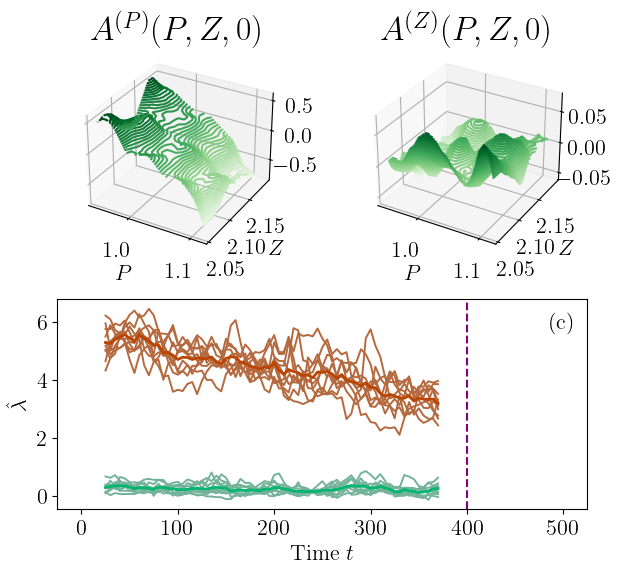

In [1155]:
mesh = samplemeshs[0][0]
kmc = samplekmcs[0][0]


fig = plt.figure(figsize = (2*3.42,2*3))


ax_00 = fig.add_subplot(2, 2, 1, projection='3d')

ax_00.contour3D(mesh[0], mesh[1], kmc[0][:,:], 50, cmap='Greens')
#ax_00.text(0.7, 2, 19, "(a)", transform=ax_00.transAxes, verticalalignment='top', bbox=props)

ax_00.set_title(r'$A^{(P)}(P,Z,0)$');

X = np.array([[mesh[i][tupel] for i in range(2)] for tupel in list(itertools.product(*[range(len(mesh[j])) for j in range(2)]))])
Y = np.array([[kmc[i][tupel] for i in range(2)] for tupel in list(itertools.product(*[range(len(mesh[j])) for j in range(2)]))])

ax_01 = fig.add_subplot(2, 2, 2, projection='3d')

ax_01.contour3D(mesh[0], mesh[1], kmc[1][:,:], 50, cmap='Greens')
#ax_01.text(0, 1.95, 1.1, "(b)", transform=ax_01.transAxes, verticalalignment='top', bbox=props)
#ax_01.scatter3D(X[:,0], X[:,1], Y[:,0].T, cmap='Greens')

ax_01.set_title(r'$A^{(Z)}(P,Z,0)$');

ax_10 = fig.add_subplot(2, 1, 2)

for i in range(samplesize):
    ax_10.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), samplelambdas[i][:,0], color = eigval1errorcolor, linewidth = errorlinewidth)
ax_10.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplelambda[:,0], color = eigval1meancolor, linewidth = theolinewidth)
for i in range(samplesize):
    ax_10.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), samplelambdas[i][:,1], color = eigval2errorcolor, linewidth = errorlinewidth)
ax_10.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplelambda[:,1], color = eigval2meancolor, linewidth = theolinewidth)
ax_10.axvline(T_measure, linestyle = "dashed", color = "purple")
ax_10.set_ylabel(r"$\hat{\lambda}$")
ax_10.text(0.93, 0.94, "(c)", transform=ax_10.transAxes, verticalalignment='top', bbox=props)
ax_10.set_xlabel("Time $t$")
ax_10.scatter([0,T],[meansamplelambda[0][0],meansamplelambda[0][0]],color="white")


# Rotate views and add labels
ax_00.view_init(30, -60); ax_01.view_init(30, -60)
ax_00.set_xlabel(r'$P$'); ax_01.set_xlabel(r'$P$')
ax_00.set_ylabel(r'$Z$'); ax_01.set_ylabel(r'$Z$')

plt.show()
#fig.savefig("Plots/2DKM_lambda" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True)

Define the Hopf-bifurcation model

In [1139]:
T = 1000 # length of the time series in units of time
OneOverDelta_t = 10 # Delta_t is the sampling time step of the time series
Delta_t = 1/OneOverDelta_t
oversampling = 10 # the SDE integration is done at a time step which is oversampling* finer than the sampling time step.
int_tspan = np.linspace(0, T, T * OneOverDelta_t*oversampling,endpoint=False)
plt_tspan = np.linspace(0, T, T * OneOverDelta_t,endpoint=False)
T_measure = round(0.8*T)
xy_0 = np.array([0,0]) # initial value of the SDE integration
epsilon = 0.01

mu_0 = 2
mu_T = 0.1
omega = 0.1


# bifurcation parameter evolution
def mu(t):
    return mu_0 * (1 - t/T) + mu_T * t/T


# deterministic evolution, subcritical Hopf bifurcation normal form
def f(xy,t):
    return np.array([-1*(mu(t) - xy[0]**2 - xy[1]**2)*xy[0] - omega*xy[1], -1*(mu(t) - xy[0]**2 - xy[1]**2)*xy[1] + omega*xy[0]])

# noise strength matrix
def G(pz,t):
    return epsilon*np.array([[1,0],[0,1]])

Integrate a collection of sample paths

In [1140]:
samplesize = 10 # number of sample paths to perform estimations on
samplepaths = []
for i in range(samplesize):
    integration = sdeint.itoint(f,G,xy_0,int_tspan)
    samplepaths.append(np.transpose(integration[::oversampling]))

Define estimation constraints

In [1141]:
windowsize = 100 * OneOverDelta_t # estimation windowsize in units of individual data points sampled at time step Delta_t
leap = 10 * OneOverDelta_t # leap between sucessive estimations in units of individual data points sampled at time step Delta_t
kmleapfactor = 10 # skip this many KM visualisations in the color plots
number_of_windows = (T_measure * OneOverDelta_t - windowsize)// leap # number of estimation windows resulting

Calculate KM coefficients and corresponding eigenvalues of linear approximation

In [1142]:
importlib.reload(KM_EWS_methods)
samplemeshs = []
samplekmcs = []
samplelambdas = []
for i in range(samplesize):
    samplemeshs.append([])
    samplekmcs.append([])
    samplelambdas.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        km_analysis_results = KM_EWS_methods.full_km_analysis_nD(samplepaths[i][:,j: j + windowsize], Delta_t, bin_number=50) # See more specifics in the file KM_EWS_methods.py
        samplemeshs[i].append(km_analysis_results[0])
        samplekmcs[i].append(km_analysis_results[1])
        samplelambdas[i].append(km_analysis_results[2])


samplelambdas = np.array(samplelambdas)
meansamplelambda = np.mean(samplelambdas, axis = 0)

Plot estimations of eigenvalues

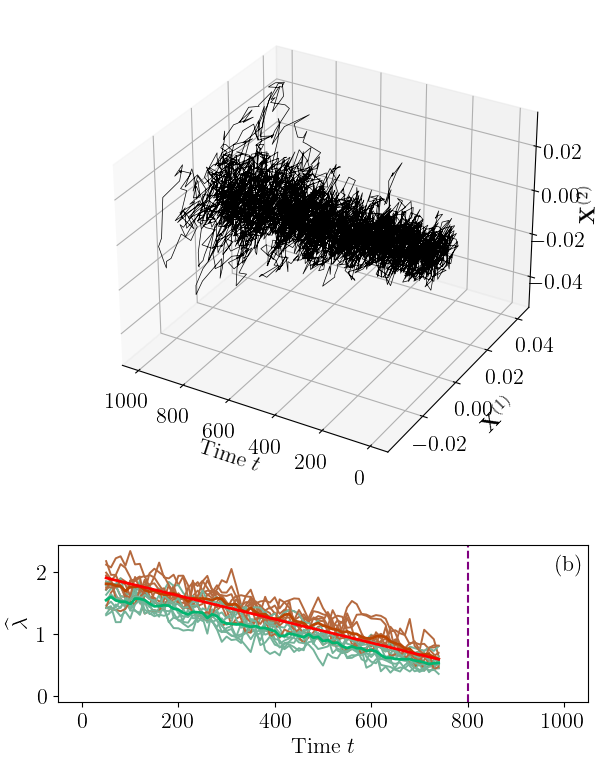

In [1144]:
fig, [xyplt, eigvalplt] = plt.subplots(nrows=2, ncols=1,figsize=(3.42*2, 4.5*2),gridspec_kw={'height_ratios': [3, 1]})
props = dict(edgecolor="none", facecolor='white', alpha=0)
xyplt.remove()
xyplt = fig.add_subplot(2,1,1,projection="3d")
xyplt.plot(plt_tspan[::OneOverDelta_t//4], samplepaths[0][0][::OneOverDelta_t//4], samplepaths[0][1][::OneOverDelta_t//4], color = samplecolor, linewidth = samplelinewidth/4)
xyplt.set_xlim([xyplt.get_xlim()[1], xyplt.get_xlim()[0]])
xyplt.set_zlabel(r"$\mathbf{X}^{(2)}$")
xyplt.set_xlabel("Time $t$")
xyplt.set_ylabel(r"$\mathbf{X}^{(1)}$")
#xyplt.text(0.94, 0.96, "(a)", transform=xyplt.transAxes, verticalalignment='top', bbox=props)
for i in range(samplesize):
    eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), samplelambdas[i][:,0], color = eigval1errorcolor, linewidth = errorlinewidth)
    eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), samplelambdas[i][:,1], color = eigval2errorcolor, linewidth = errorlinewidth)
eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplelambda[:,0], color = eigval1meancolor, linewidth = theolinewidth)
eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplelambda[:,1], color = eigval2meancolor, linewidth = theolinewidth)
eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), [mu(t) for t in range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t))], color = theocolor, linewidth = theolinewidth)
eigvalplt.scatter([0,T],[meansamplelambda[0][0],meansamplelambda[0][0]],color="white")
eigvalplt.axvline(T_measure, linestyle = "dashed", color = "purple")
eigvalplt.set_ylabel("$\widehat{\lambda}$")
eigvalplt.set_ylim(-0.1,eigvalplt.get_ylim()[1])
eigvalplt.text(0.94, 0.94, "(b)", transform=eigvalplt.transAxes, verticalalignment='top', bbox=props)
eigvalplt.set_xlabel("Time $t$")

#[plots.yaxis.set_label_coords(-0.1,.5) for plots in [xyplt, eigvalplt]]

#fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.99, hspace=.1, wspace=.2)

#fig.savefig("Plots/HopfEigVals" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True) 
